In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

* `data` contains the data from the runs generated by Guild. This contains the mean $ r^2 $ for all of the models of a specific configuration. And the configuration itsel.

* `drug_data` contains the hyperparameter values for each of the trained models and the $ r^2 $ value obtained

In [66]:
data = pd.read_csv('data/runs/n_results.csv', index_col='run')
drug_data = pd.read_csv('data/runs/Old/full_drug_new.csv', index_col='run').rename({'Unnamed: 0':'Drug'}, axis=1)

In [132]:
data.columns

Index(['operation', 'started', 'time', 'status', 'label', 'ajive', 'ccle',
       'ctrp', 'cutoff', 'drugs', 'feda', 'fs', 'gdsc', 'metric', 'model', 'n',
       'norm', 'test', 'threshold', 'step', 'r_2_mean', 'r_2_std', 'seconds',
       'datasets'],
      dtype='object')

In [67]:
drug_data.columns

Index(['C', 'Drug', 'algorithm', 'alpha', 'bootstrap', 'cache_size', 'coef0',
       'copy_X', 'criterion', 'degree', 'epsilon', 'fit_intercept', 'gamma',
       'kernel', 'l1_ratio', 'leaf_size', 'max_depth', 'max_features',
       'max_iter', 'max_leaf_nodes', 'mean_absolute_error',
       'mean_squared_error', 'median_absolute_error', 'metric',
       'metric_params', 'min_impurity_decrease', 'min_impurity_split',
       'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf',
       'n_estimators', 'n_jobs', 'n_neighbors', 'normalize', 'oob_score', 'p',
       'positive', 'precompute', 'presort', 'r2_score', 'random_state',
       'selection', 'shrinking', 'splitter', 'tol', 'verbose', 'warm_start',
       'weights'],
      dtype='object')

# Data cleaning

In [68]:
data = data[data['status']=='completed']
data = data[data['r_2_mean'].notnull()]

data['time'] = pd.to_timedelta(data['time'])
data['started'] = pd.to_datetime(data['started'])
data['seconds'] = data['time'].apply(lambda x:x.seconds)

data['datasets'] = data['gdsc']+data['ctrp']+data['ccle']
data = data[data['datasets']>0]

# The only valid daata
data = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')]

# IC/EC quality effect on $ r^2 $

Here we determine how many runs were done for each drug

In [69]:
drugs = drug_data.groupby('Drug').agg({'r2_score': ['mean', 'std']})
#drugs['runs'] = [drug_data[drug_data['Drug']==i].shape[0] for i in drugs.index]

In [70]:
ctrp = pd.read_csv('data/Processed/ctrp_poz_dr.csv')
gdsc = pd.read_csv('data/Processed/gdsc_poz_dr.csv')
ccle = pd.read_csv('data/Processed/ccle_poz_dr.csv')

We create EC and IC quality columns where Low, Medium and High quality CCLs are given a -1, 0 and 1 score respectively

In [71]:
scoring = {'Low':-1, 'Medium':0, 'High':1}
ctrp['IC'] = ctrp['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)

ctrp['EC'] = ctrp['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)

In [72]:
dr = pd.concat([ctrp, gdsc, ccle], sort=True)

Here we calculate the average EC/IC quality for each of the drug

In [73]:
c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

Then we join the run data with the model data, setting Drugname and run pairs as the index. We select non-compromised runs and drop dubplicate rows. Finally, we give each run a quality score equal to the IC or EC quality of the drug used depending on what metric the model was trained on

In [124]:
full = drug_data.join(data, on='run', rsuffix='_drug').reset_index().set_index(['Drug', 'run'])
full = full[full['started'] > pd.to_datetime('2020-04-15 18:00:00')].drop_duplicates()
full['Quality'] = [c_dict.loc[i[0]]['IC'] if full.loc[i]['metric_drug'][0]=='AUC_IC50' else c_dict.loc[i[0]]['EC'] for i in full.index]

/Users/admin/Desktop/Thesis/Code/phc-data-pipeline/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


In [126]:
full['Quality'] = full['Quality'].fillna(-1)

Here we plot IC/EC quality vs $ r^2 $. We observe clear drop-offs for very low quality and for very high quality. We will drop all runs under a specific quality threhsold since these models can be considered faulty (the data they received wasn't good)

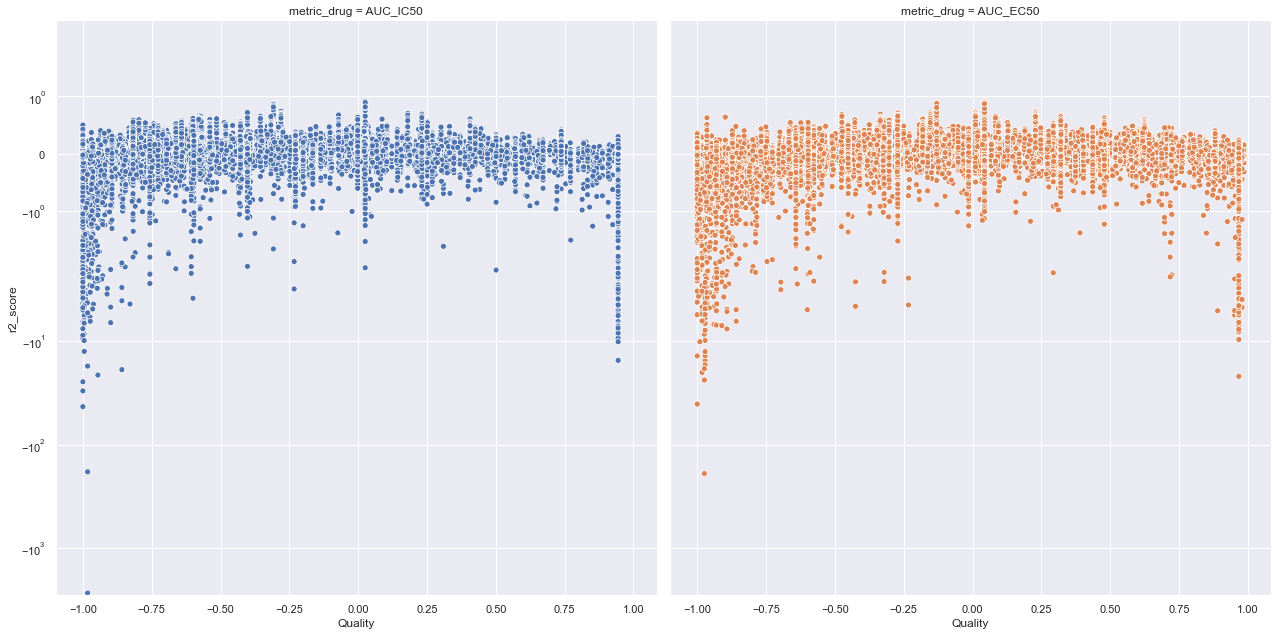

In [127]:
sns.set()
g = sns.relplot(x='Quality', y='r2_score', data=full, kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)
g.set(yscale='symlog')
g.set(ylim=(None, 3))
#plt.savefig('IC quality vs r2.png')

Now we plot the IC/EC quality vs average $ r^2 $ of models trying to predict resistance to a specific drug. All models predicting the resistance to a drug with very low average quality are dropped.

In [128]:
drug_ic = full.groupby('Drug').mean()

In [129]:
drug_ic['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in drug_ic.index]

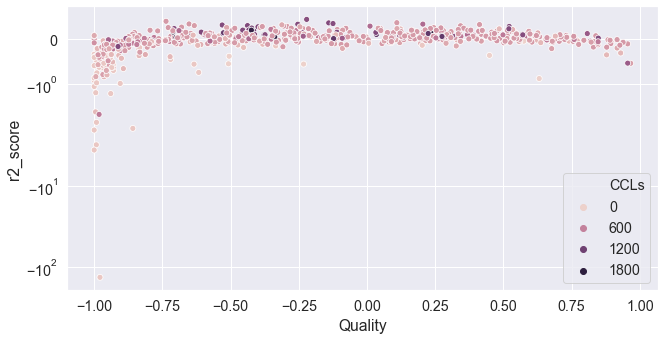

In [130]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(1.9*5,5))
g = sns.scatterplot(x='Quality', y='r2_score', data=drug_ic, hue='CCLs', ax=ax, legend='brief')
g.set(yscale='symlog')
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('graphs/ICqualitylog.eps', format='eps')

## A threshold of -0.95 IC quality is set 
All runs below that are disregarded

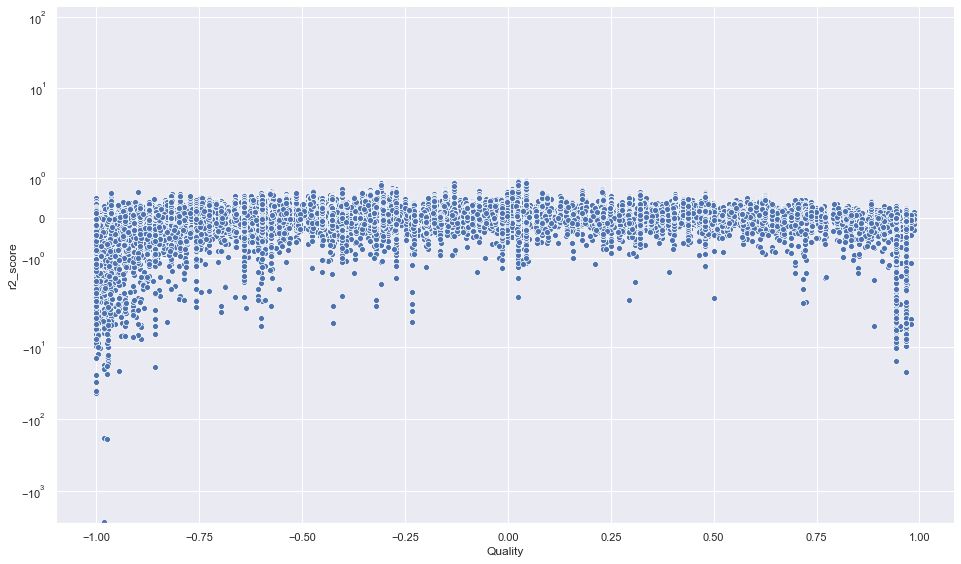

In [131]:
sns.set(font_scale=1)
g = sns.relplot(x='Quality', y='r2_score', data=full, kind='scatter', height=8, aspect=1.7)
g.set(yscale='symlog')
#plt.legend(loc = 'lower right')
#plt.savefig('Chop.png')

In [20]:
full = full[full['Quality']>-0.95]

In [21]:
full = full[full['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full['norm'] = full['norm'].fillna('None')

Here we create a dataframe containing the average $ r^2 $ for all drugs

In [21]:
d_r = full[['Drug', 'r2_score']].groupby('Drug').mean()

Here we calculate the drug-agnostic $ r^2 $ for all different runs, this is done by substracting the average $ r^2 $ for the drug being modeled from the $ r^2 $ obtained

In [22]:
full['r2'] = [full.loc[i]['r2_score']-d_r.loc[full.loc[i]['Drug']]['r2_score'] for i in full.index]

Here we create a column that contains, feda, ajive or none depending on the domain adaptation method used

In [46]:
full['da'] = ['feda' if full.loc[i]['feda'] else 'ajive' if full.loc[i]['ajive'] is not None and full.loc[i]['ajive']>0 else 'none' for i in full.index]